# THE Winter School

# **Machine Learning for Prediction**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)


We have acces to web-scraped data from the online auction platform *MyLemons* and estimate the hedonic prices of used-cars. We restrict the sample to BMW 320 series, Opel Astra, Mercedes C-class, VW Golf, and VW Passat. We select used-cars with a mileage between 10,000-200,000 km and an age between 1-20 years. The data is stored in the file *mylemon.csv*.  

We observe the following variables:


|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 EUR |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*mileage2, mileage3, mileage4, age_car_years2, age_car_years3, age_car_years4*| Squared, cubic, and quadratic *mileage* and *age_car_years* |
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional sellers) |
|*other_car_owner*| Number of previous car owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in g/km)|
|*dur_next_ins_0*| Dummy indicating that the duration until the next general inspection is less than a years |
|*dur_next_ins_1_2*| Dummy indicating that the duration until the next general inspection is between 1 and 2 years |
|*new_inspection*| Dummy indicating that the used car has a new general inspection |
|*euro_1, euro_2, euro_3, euro_4, euro_5, euro_6*| Dummies for EURO emission norms |

## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('tidyverse','glmnet','corrplot','plotmo')

# Load packages
for(pkg in pkgs){
    install.packages(pkg)
    library(pkg, character.only = TRUE)
}

print('All packages successfully installed and loaded.')

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
corrplot 0.84 loaded
Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos


[1] "All packages successfully installed and loaded."


## Load Data 

We select a subsample of 200 used-cars in order to decrease the computation time while you are testing your code. We can use the entire sample of 104,721 used cars after we are finised with programming.

In [2]:
########################  Load Data Frame  ########################

# Load data 
data_raw <- read.csv("Data/mylemon.csv",header=TRUE, sep=",")

set.seed(1001) # set starting value for random number generator
# Selection of Subsample size, max. 104,721 observations
# Select smaller subsample to decrease computation time
n_obs <- 200
df <- data_raw %>%
  dplyr::sample_n(n_obs) 

print('Data frame successfully loaded.')

[1] "Data frame successfully loaded."


## Construct Training and Estimation Samples

We want to compare the relative prediction power of different estimation procedures based on the out-of-sample $R^2$. For this purpose, we separate training and test samples. 

In [3]:
########################  Take Hold-Out-Sample  ########################
set.seed(1001) # set starting value for random number generator

# Partition data in training and test sample
df_part <- modelr::resample_partition(df, c(train = 0.8, test = 0.2))
df_train <- as.data.frame(df_part$train) # Training sample
df_test <- as.data.frame(df_part$test) # Test sample

# Outcome
price_train <- as.matrix(df_train[,2])
price_test <- as.matrix(df_test[,2])

# Covariates
covariates_train <- as.matrix(df_train[,c(3:ncol(df_train))])
covariates_test <- as.matrix(df_test[,c(3:ncol(df_test))])

print('The data is now ready for your first analysis!')

[1] "The data is now ready for your first analysis!"


## Correlation Matrix

Warning message in cor(covariates_train):
“the standard deviation is zero”

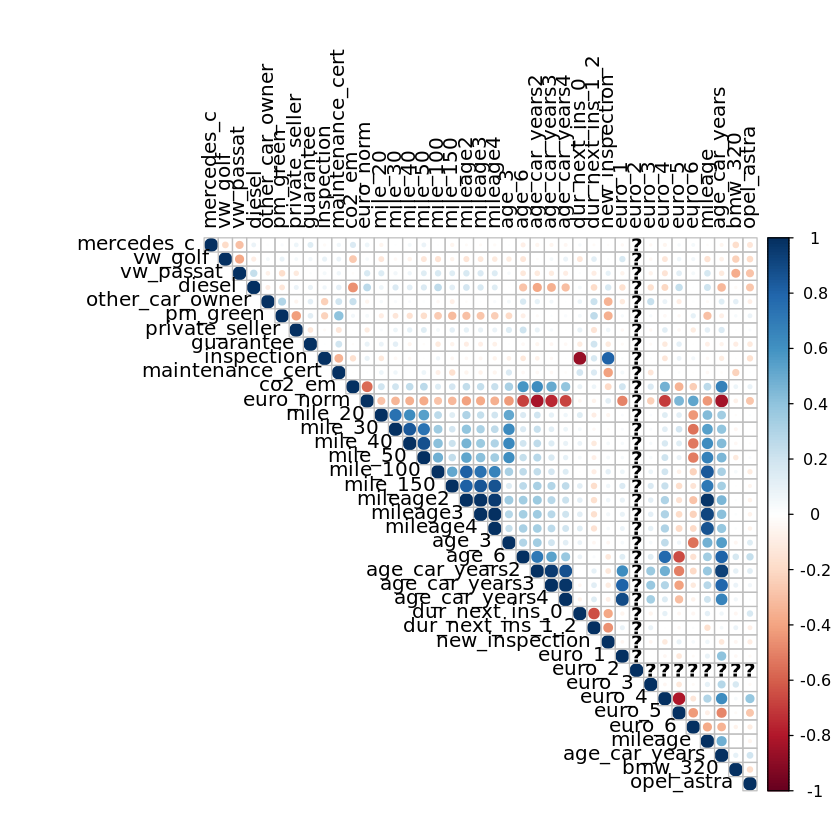

In [4]:
########################  Correlation Matrix  ########################

corr = cor(covariates_train)
corrplot(corr, type = "upper", tl.col = "black")


# OLS Model

We estimate the used-car prices using an OLS model including all covariates.

In [5]:
########################  OLS Model  ######################## 

# Estimate OLS model
ols <- lm(price_train ~., as.data.frame(covariates_train))
# Some variables might be dropped because of perfect colinearity 
summary(ols) # Plot table of coefficients


Call:
lm(formula = price_train ~ ., data = as.data.frame(covariates_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-11.6957  -1.3266  -0.2698   1.2339  11.4532 

Coefficients: (6 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.115e+00  1.351e+01  -0.157 0.875880    
mercedes_c        4.862e+00  1.278e+00   3.804 0.000221 ***
vw_golf           1.038e+00  1.104e+00   0.940 0.349006    
vw_passat         3.259e+00  1.086e+00   3.002 0.003240 ** 
diesel            4.328e+00  9.819e-01   4.407 2.23e-05 ***
other_car_owner   1.232e-01  4.335e-01   0.284 0.776652    
pm_green         -2.436e-01  1.067e+00  -0.228 0.819710    
private_seller    2.994e-02  9.054e-01   0.033 0.973673    
guarantee         1.518e+00  1.020e+00   1.488 0.139171    
inspection        1.587e+00  8.271e-01   1.919 0.057233 .  
maintenance_cert -4.061e-01  8.030e-01  -0.506 0.613964    
co2_em            1.035e-01  1.900e-02   5.

Calculate the fitted values in the training and test sample.

In [6]:
# Training sample fitted values
fit1_train <- predict.lm(ols)

# Test sample fitted values
fit1_test <- predict.lm(ols, newdata = data.frame(covariates_test))

print('Fitted values are calculated.')

Warning message in predict.lm(ols, newdata = data.frame(covariates_test)):
“prediction from a rank-deficient fit may be misleading”

[1] "Fitted values are calculated."


Evaluate the in- and out-of-sample performance of OLS using the $R^2$.

In [7]:
# R-squared in training sample
rsquared_train <- round(1-mean((price_train- fit1_train)^2)/mean((price_train - mean(price_train))^2),digits=3)
#print(paste0("In-Sample MSE OLS: ", mse1_in))

# R-squared in test sample
rsquared_test <- round(1-mean((price_test - fit1_test)^2)/mean((price_test - mean(price_test))^2),digits=3)

print(paste0("Training Sample R-squared OLS: ", rsquared_train))
print(paste0("Test Sample R-squared OLS: ", rsquared_test))

[1] "Training Sample R-squared OLS: 0.851"
[1] "Test Sample R-squared OLS: 0.702"


# LASSO

The LASSO minimises the objective function
\begin{equation*}
\min_{\beta} \left\{ \sum_{i=1}^{N} \left( Y_i-  \beta_0 -\sum_{j=1}^{p}X_{ij}\beta_j \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}.
\end{equation*}
First we have to find the optimal tuning parameter $\lambda$ via cross-validation (CV).

[1] "Lambda minimising CV-MSE: 0.03"
[1] "Lambda 1 standard error rule: 0.366"
[1] "Number of selected covariates (lambda.min): 24"
[1] "Number of selected covariates (lambda.1se): 14"


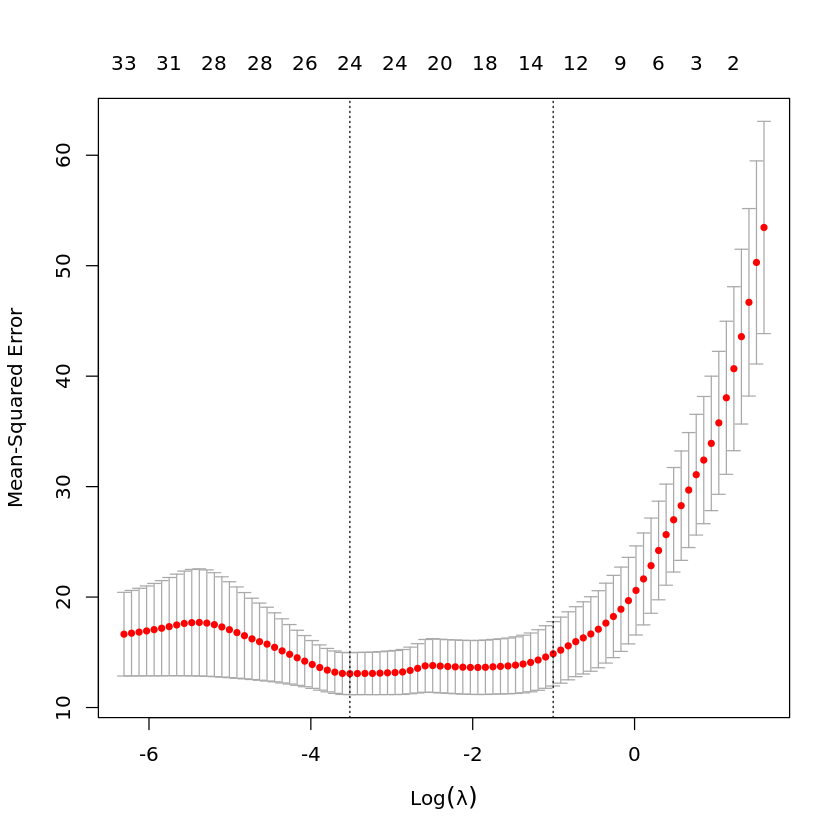

In [8]:
########################  CV-LASSO  ######################## 
p = 1 # 1 for LASSO, 0 for Ridge

set.seed(10101)
lasso <- cv.glmnet(covariates_train, price_train, alpha=p, family = "gaussian", 
                          nlambda = 100, type.measure = 'mse')
# nlambda specifies the number of different lambda values on the grid (log-scale)
# type.measure spciefies that the optimality criteria is the MSE in CV-samples
# alpha allows to select between Ridge and LASSO
# family allows to specify whether the outcome variable has limited support
# family = "gaussian" is the default (no limited support)

# Plot MSE in CV-Samples for different values of lambda
plot(lasso)

# Optimal lambda values
# Minimal MSE
print(paste0("Lambda minimising CV-MSE: ", round(lasso$lambda.min,digits=3)))
# 1 standard error rule reduces the number of included covariates
print(paste0("Lambda 1 standard error rule: ", round(lasso$lambda.1se,digits=3)))

# Number of non-zero coefficients
# Minimal MSE
print(paste0("Number of selected covariates (lambda.min): ",lasso$glmnet.fit$df[lasso$glmnet.fit$lambda==lasso$lambda.min]))
# 1 standard error rule reduces the number of included covariates
print(paste0("Number of selected covariates (lambda.1se): ",lasso$glmnet.fit$df[lasso$glmnet.fit$lambda==lasso$lambda.1se]))


## Plot LASSO Structure

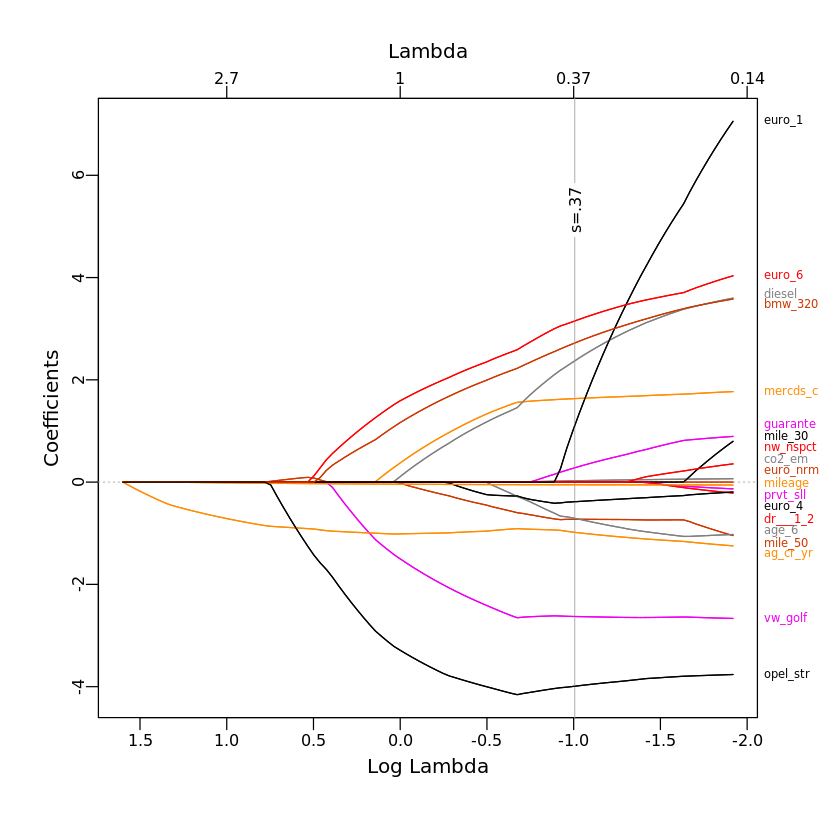

In [9]:
########################  Visualisation of LASSO  ######################## 

set.seed(10101)
mod <- glmnet(covariates_train, price_train, lambda.min.ratio = lasso$lambda.min, alpha=p)
maxcoef<-coef(lasso)
coef<-dimnames(maxcoef[maxcoef[,1]!=0,0])[[1]]
allnames<-dimnames(maxcoef[maxcoef[,1]!=0,0])[[1]][order(maxcoef[maxcoef[,1]!=0,ncol(maxcoef)],decreasing=TRUE)]
allnames<-setdiff(allnames,allnames[grep("Intercept",allnames)])

plot_glmnet(mod,label=TRUE,s=lasso$lambda.1se)

## Plot LASSO Coefficients

In [10]:
########################  Plot LASSO Coefficients  ########################

print('LASSO coefficients')

glmcoef<-coef(lasso, lasso$lambda.1se)
print(glmcoef)
# the LASSO coefficients are biased because of the penalty term

[1] "LASSO coefficients"
40 x 1 sparse Matrix of class "dgCMatrix"
                           1
(Intercept)      20.45901523
mercedes_c        1.63263911
vw_golf          -2.62695539
vw_passat         .         
diesel            2.37157811
other_car_owner   .         
pm_green          .         
private_seller    .         
guarantee         0.27884571
inspection        .         
maintenance_cert  .         
co2_em            0.02618487
euro_norm         .         
mile_20           .         
mile_30           .         
mile_40           .         
mile_50          -0.72427098
mile_100          .         
mile_150          .         
mileage2          .         
mileage3          .         
mileage4          .         
age_3             .         
age_6            -0.70006934
age_car_years2    .         
age_car_years3    .         
age_car_years4    .         
dur_next_ins_0    .         
dur_next_ins_1_2  .         
new_inspection    .         
euro_1            1.11296932
euro_

## In-Sample Performance Measures

In [11]:
######################## Training Sample Performance of LASSO  ######################## 

# Estimate LASSO model 
# Use Lambda that minizes CV-MSE
set.seed(10101)
lasso.fit.min <- glmnet(covariates_train, price_train, lambda = lasso$lambda.min)
yhat.lasso.min <- predict(lasso.fit.min, covariates_train)

# Use 1 standard error rule
set.seed(10101)
lasso.fit.1se <- glmnet(covariates_train, price_train, lambda = lasso$lambda.1se)
yhat.lasso.1se <- predict(lasso.fit.1se, covariates_train)

# In-sample performance measures
print(paste0("In-Sample R-squared OLS: ", rsquared_train))

rsquared2_train <- round(1-mean((price_train - yhat.lasso.min)^2)/mean((price_train - mean(price_train))^2),digits=3)
print(paste0("In-Sample R-squared Lasso (lambda.min): ", rsquared2_train))

rsquared3_train <- round(1-mean((price_train - yhat.lasso.1se)^2)/mean((price_train - mean(price_train))^2),digits=3)
print(paste0("In-Sample R-squared Lasso (lambda.1se): ", rsquared3_train))

[1] "In-Sample R-squared OLS: 0.851"
[1] "In-Sample R-squared Lasso (lambda.min): 0.838"
[1] "In-Sample R-squared Lasso (lambda.1se): 0.78"


## Out-of-Sample Performance Measures

In [12]:
######################## Test Sample Performance of LASSO  ######################## 

# Extrapolate Lasso fitted values totest sample
yhat.lasso.min <- predict(lasso.fit.min, covariates_test)
yhat.lasso.1se <- predict(lasso.fit.1se, covariates_test)

# Out-of-sample performance measures
print(paste0("Out-of-Sample R-squared OLS: ", rsquared_test))

rsquared2_test <- round(1-mean((price_test - yhat.lasso.min)^2)/mean((price_test - mean(price_test))^2),digits=3)
print(paste0("Out-of-Sample R-squared Lasso (lambda.min): ", rsquared2_test))

rsquared3_test <- round(1-mean((price_test - yhat.lasso.1se)^2)/mean((price_test - mean(price_test))^2),digits=3)
print(paste0("Out-of-Sample R-squared Lasso (lambda.1se): ", rsquared3_test))

[1] "Out-of-Sample R-squared OLS: 0.702"
[1] "Out-of-Sample R-squared Lasso (lambda.min): 0.803"
[1] "Out-of-Sample R-squared Lasso (lambda.1se): 0.812"


# Exercises:

1. How do the results change when you increase the sample size to 104,721 observations?

2. Predict the used car prices using a Ridge instead of a Lasso model. Which estimator has the better performance?

3. Estimate the Post-Lasso coefficients. Do they differ from the Lasso coefficients? Do the performances of the Lasso and Post-Lasso estimators differ?

In [ ]:
######## Put Your Code Here ########







####################################